## Wikipedia Page View Retrieval and Digital Data Comparisons

### Pageview Retrieval

In [1]:
import pandas as pd
import json
from ast import literal_eval
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import json
import base64
import requests
import bs4
from bs4 import BeautifulSoup
import re

from requests.structures import CaseInsensitiveDict
#from ratelimit import limits, RateLimitException, sleep_and_retry
# pip install ratelimit

In [6]:
# Read in speciesinfo CSV
species = pd.read_csv("csv/speciesinfo.csv", sep = ";")
species.drop_duplicates(inplace = True)
species = species.reset_index(drop = True)
len(species)

In [ ]:
# pip3 install wikipedia-api
import wikipediaapi
# only english language pages
api = wikipediaapi.Wikipedia('en')

wikiurls = []
# loop through the unique species names
for name in species['scientific_name'].unique():
    # Spaces to be replaced with underscore for Wiki's API
    name = name.replace(" ", "_")
    # retrieve each species' page, will redirect when called with scientifc name
    p = api.page(name)
    try:
        # Fullurl will contain the title of the species' wiki article
        data = {'url': p.fullurl, 'scientific_name': name}
        wikiurls.append(data)
    # species did not return with a valid url, no page exists for the species
    except KeyError:
        pass
    
# investigate how many species left   
len(wikiurls)

In [31]:
def WikiPageView(title):
    """
    Function to call Wikipedia's Pageview API
    
    Parameters: string
    
    """
    
    # Calling monthly page views of each species from 2015-2020
    address = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/user/" + title + "/monthly/2015010100/2020123100"

    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"
    # Personal username for identification for the Wikipedia API
    headers = {'User-Agent': 'reddalisa/3.10.6 (alisa.redding@helsinki.fi)'}
    
    resp = requests.get(address, headers=headers)
    details = resp.json()
    
    return details 
      
    
# Create an empty list to store the pageviews results into
newframe = []  

# loop over the urls to extract the titles of the wikipages
for n in range(len(wikiurls)):
    name = wikiurls[n]['url'].removeprefix("https://en.wikipedia.org/wiki/")
    # using the extracted name, run through the function
    result = WikiPageView(name)
    sci_name = wikiurls[n]['scientific_name']
    
    try:
        # loop over the json results to store the relevant information 
        for n in range(len(result['items'])):
            title = result['items'][n]['article']
            date = result['items'][n]['timestamp']
            # Remove 00 at end of date string that is marking the hour
            date = date[:-2]
            view = result['items'][n]['views']
            
            # create a dictionary object 
            data = {'title': title, 'date': date, 'views': view, 'scientific_name' : sci_name}
            newframe.append(data)
    # Some pages have not been incorporated into the PageViews API yet, they will be passed
    except KeyError:
        pass



In [37]:
# Create a dataframe from the list
#wikipage = pd.DataFrame(newframe)
#wikipage["datetime"] = wikipage["date"].apply(pd.to_datetime)
wikipage = wikipage.drop(columns = 'date')
wikipage['title'] = wikipage["title"].apply(lambda x: x.replace("_", " "))
wikipage['scientific_name'] = wikipage["scientific_name"].apply(lambda x: x.replace("_", " "))
#len(wikipage['name'].unique())

In [48]:
# view highest view count
wikipage.sort_values(by="views", ascending = False)

title   views       scientific_name   datetime
2762                    Tiger  694465       Panthera tigris 2020-03-01
9262                Red panda  652891       Ailurus fulgens 2017-05-01
614                      Lion  574872          Panthera leo 2017-03-01
650                      Lion  574083          Panthera leo 2020-03-01
2763                    Tiger  540666       Panthera tigris 2020-04-01
...                       ...     ...                   ...        ...
34056  Milne-Edwards's sifaka       0  Propithecus edwardsi 2018-07-01
34057  Milne-Edwards's sifaka       0  Propithecus edwardsi 2018-08-01
34058  Milne-Edwards's sifaka       0  Propithecus edwardsi 2018-09-01
34059  Milne-Edwards's sifaka       0  Propithecus edwardsi 2018-10-01
34043  Milne-Edwards's sifaka       0  Propithecus edwardsi 2017-05-01

[35868 rows x 4 columns]

In [46]:
speciesinfo = pd.merge(species, wikipage.groupby('scientific_name')['views'].sum().reset_index(), on='scientific_name', how = 'inner').drop_duplicates()

In [77]:
top20 = wikipage.groupby('name')['views'].sum().nlargest(20).reset_index()

In [47]:
speciesinfo.to_csv("csv/fullspeciesinfo.csv", sep = ";", index = False)

In [52]:
wikipage.to_csv("csv/wikipageviews.csv", sep = ";", index = False)

## Temporal Visualization

### Articles: Facebook shares

In [111]:
articles = pd.read_csv("articles-w-full_engagement.csv", sep = "~")

In [115]:
articles = articles.drop(columns = ["date_saved", "sharecount"])
articles['date'] = pd.to_datetime(articles['date'])

In [125]:
articleshares = articles.groupby([(articles.date.dt.year), (articles.date.dt.month), (articles.scientific_name)])['shares'].sum()\
                .sort_values(ascending=False).rename_axis(["Year", "Month", "scientific_name"]).reset_index()

ar16 = articleshares.loc[articleshares['Year'].isin([2016])]
chosen = ar16.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar16 = ar16.loc[ar16['scientific_name'].isin(chosen)]

ar17 = articleshares.loc[articleshares['Year'].isin([2017])]
chosen = ar17.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar17 = ar17.loc[ar17['scientific_name'].isin(chosen)]

ar18 = articleshares.loc[articleshares['Year'].isin([2018])]
chosen = ar18.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar18 = ar18.loc[ar18['scientific_name'].isin(chosen)]

ar19 = articleshares.loc[articleshares['Year'].isin([2019])]
chosen = ar19.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar19 = ar19.loc[ar19['scientific_name'].isin(chosen)]

ar20 = articleshares.loc[articleshares['Year'].isin([2020])]
chosen = ar20.sort_values('shares').drop_duplicates('scientific_name',keep='last').tail(5)
chosen = chosen['scientific_name'].values.tolist()
ar20 = ar20.loc[ar20['scientific_name'].isin(chosen)]

In [213]:
shared = articles.groupby('scientific_name')['shares'].sum().nlargest(10).reset_index()['scientific_name'].values.tolist()
articspan = articles.loc[articles['scientific_name'].isin(shared)]
articspan = articspan.loc[articspan.date.dt.year > 2015]
articspan = articspan.reset_index(drop = True)

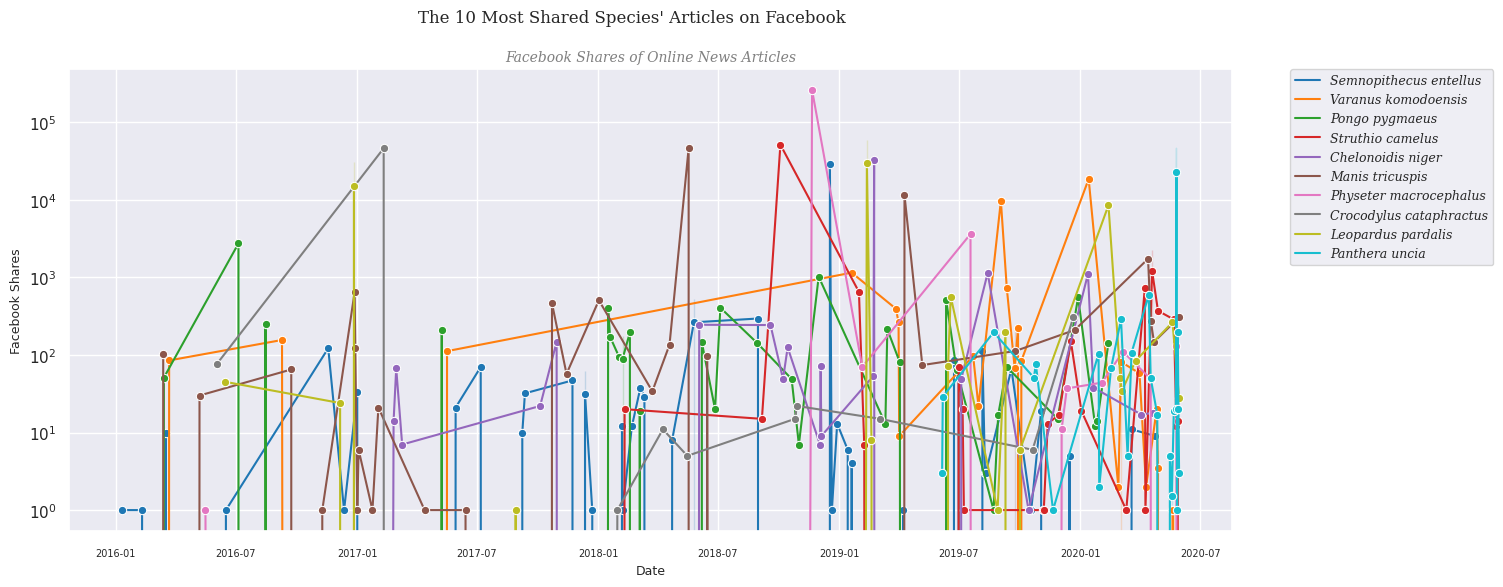

In [214]:
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15,6)})
ax = sns.lineplot(
    x = 'date',
    y = 'shares',
    hue = 'scientific_name',
    data = articspan, 
    marker = "o", 
    palette = 'tab10'
)

ax.set_xlabel('Date', fontsize=9)
ax.set_ylabel('Facebook Shares', fontsize=9)
ax.set_yscale('log')


# Add suptitle above the title
plt.suptitle("The 10 Most Shared Species' Articles on Facebook\n", fontsize=12, family = 'Serif')

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('Facebook Shares of Online News Articles', fontsize = 10, color="grey", style='italic', family = 'Serif')

font = font_manager.FontProperties(family='Serif',
                                   weight='regular',
                                   style='italic', size=9)

#tick_spacing = 1
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis='x', rotation=0, length = 9, labelsize = 7, left = True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop=font)
#plt.savefig('figures/2016_5species.png', bbox_inches = 'tight')

### Wikipedia Pageviews

In [2]:
wiki = pd.read_csv("csv/wikipageviews.csv", sep = ";")

In [4]:
wiki["datetime"] = pd.to_datetime(wiki['datetime'])

In [5]:
temporal_wiki = wiki.groupby([(wiki.datetime.dt.year), (wiki.datetime.dt.month), (wiki.scientific_name)])['views'].sum()\
                .sort_values(ascending=False).rename_axis(["Year", "Month", "scientific_name"]).reset_index()

In [105]:
# Finding 5 most popular species of each year and plot their popularity over the year
yr20 = temporal_wiki.loc[temporal_wiki['Year'].isin([2020])]
chosen20 = yr20.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen20 = chosen20['scientific_name'].values.tolist()
yr20 = yr20.loc[yr20['scientific_name'].isin(chosen20)]

yr19 = temporal_wiki.loc[temporal_wiki['Year'].isin([2019])]
chosen19 = yr19.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen19 = chosen19['scientific_name'].values.tolist()
yr19 = yr19.loc[yr19['scientific_name'].isin(chosen19)]

yr18 = temporal_wiki.loc[temporal_wiki['Year'].isin([2018])]
chosen18 = yr18.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen18 = chosen18['scientific_name'].values.tolist()
yr18 = yr18.loc[yr18['scientific_name'].isin(chosen18)]

yr17 = temporal_wiki.loc[temporal_wiki['Year'].isin([2017])]
chosen17 = yr17.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen17 = chosen17['scientific_name'].values.tolist()
yr17 = yr17.loc[yr17['scientific_name'].isin(chosen17)]

yr16 = temporal_wiki.loc[temporal_wiki['Year'].isin([2016])]
chosen16 = yr16.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(5)
chosen16 = chosen16['scientific_name'].values.tolist()
yr16 = yr16.loc[yr16['scientific_name'].isin(chosen16)]

In [190]:
uniques = list(set(chosen20 + chosen19 + chosen18 + chosen17 + chosen16))
test = wiki.sort_values('views').drop_duplicates('scientific_name',keep='last').tail(10)['scientific_name'].values.tolist()
topoverall = wiki.groupby('scientific_name')['views'].sum().nlargest(10).reset_index()['scientific_name'].values.tolist()
timespan = wiki.loc[wiki['scientific_name'].isin(topoverall)]

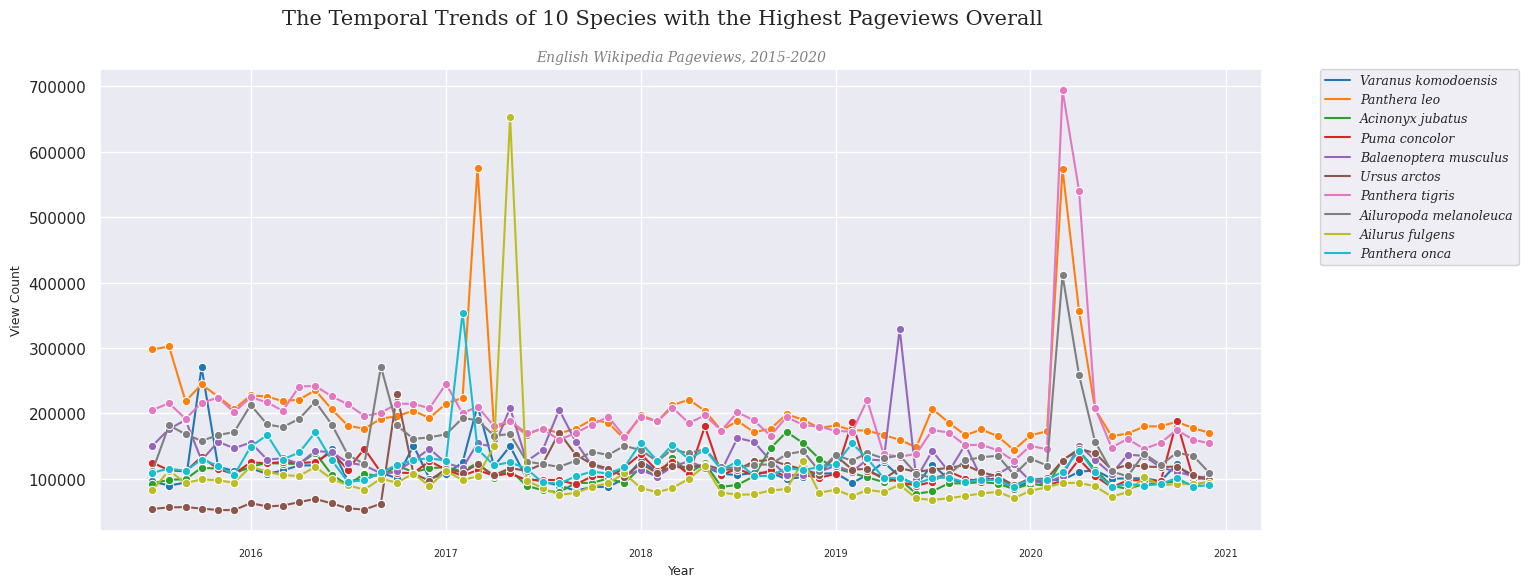

In [194]:
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15,6)})
ax = sns.lineplot(
    x = 'datetime',
    y = 'views',
    hue = 'scientific_name',
    data = timespan, 
    marker = "o", 
    palette = 'tab10'
)

ax.set_xlabel('Year', fontsize=9)
ax.set_ylabel('View Count', fontsize=9)
#plt.figure(figsize=(15,6))

# Add suptitle above the title
plt.suptitle("The Temporal Trends of 10 Species with the Highest Pageviews Overall\n", fontsize=15, family = 'Serif')


# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('English Wikipedia Pageviews, 2015-2020', fontsize = 10, color="grey", style='italic', family = 'Serif')

font = font_manager.FontProperties(family='Serif',
                                   weight='regular',
                                   style='italic', size=9)

#tick_spacing = 1
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis='x', rotation=0, length = 9, labelsize = 7, left = True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop=font)
plt.savefig('figures/wiki10overalltopspecies.png', bbox_inches = 'tight')

In [44]:
year2020 = temporal_wiki.loc[temporal_wiki['Year'].isin([2020])].drop_duplicates("Month").sort_values("Month")
year2019 = temporal_wiki.loc[temporal_wiki['Year'].isin([2019])].drop_duplicates("Month").sort_values("Month")
year2018 = temporal_wiki.loc[temporal_wiki['Year'].isin([2018])].drop_duplicates("Month").sort_values("Month")
year2017 = temporal_wiki.loc[temporal_wiki['Year'].isin([2017])].drop_duplicates("Month").sort_values("Month")
year2016 = temporal_wiki.loc[temporal_wiki['Year'].isin([2016])].drop_duplicates("Month").sort_values("Month")

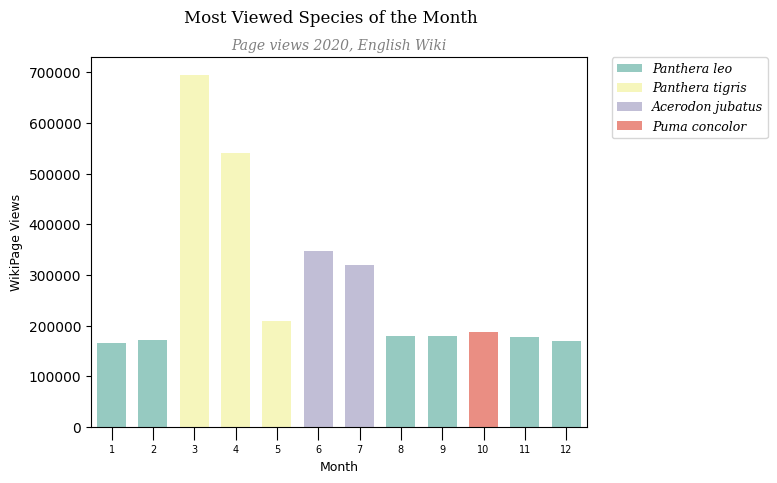

In [41]:
import seaborn as sns
import matplotlib.font_manager as font_manager

ax = sns.barplot(
    x = 'Month',
    y = 'views',
    hue = 'scientific_name',
    data = year2020, 
    width = 0.7, palette = 'Set3', dodge = False
)
ax.set_xlabel('Month', fontsize=9)
ax.set_ylabel('WikiPage Views', fontsize=9)


# Add suptitle above the title
plt.suptitle("Most Viewed Species of the Month\n", fontsize=12, family = 'Serif')

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('Page views 2020, English Wiki', fontsize = 10, color="grey", style='italic', family = 'Serif')

font = font_manager.FontProperties(family='Serif',
                                   weight='regular',
                                   style='italic', size=9)

ax.tick_params(axis='x', rotation=0, length = 9, labelsize = 7, left = True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop=font)
plt.savefig('figures/2020_wikipageviews.png', bbox_inches = 'tight')

In [47]:
top20wiki = wiki.groupby('scientific_name')['views'].sum().nlargest(20).reset_index()

In [78]:
# Read in the CITES data to join with the top 10 (or 20) most reported on species 
cites1 = pd.read_csv("csv/cites1.csv", delimiter = ';')

# Keep only most relevant columns
cites1 = cites1[['Kingdom', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Scientific Name', 'Listing', 'NativeDistributionFullNames', 'Extinct_Distribution']]

cites1 = cites1.rename(columns = {'Scientific Name' : 'scientific_name'})

In [56]:
# Do the same for the entire dataframe
top20= top20.merge(cites1, on = 'scientific_name', how = 'left').drop_duplicates().reset_index(drop=True)

In [59]:
top20wiki

scientific_name   views   Kingdom     Class           Order  \
0      Araucaria araucana  884780   Plantae       NaN         Pinales   
1             Canis lupus  315399  Animalia  Mammalia       Carnivora   
2        Saussurea costus  173419   Plantae       NaN       Asterales   
3            Ursus arctos  150634  Animalia  Mammalia       Carnivora   
4         Dalbergia nigra  138788   Plantae       NaN         Fabales   
5    Encephalartos woodii  124417   Plantae       NaN       Cycadales   
6        Peristeria elata  117725   Plantae       NaN      Orchidales   
7            Panthera leo  103654  Animalia  Mammalia       Carnivora   
8           Panthera onca   98270  Animalia  Mammalia       Carnivora   
9         Aloe polyphylla   97816   Plantae       NaN        Liliales   
10     Telmatobius culeus   96224  Animalia  Amphibia           Anura   
11            Oryx dammah   87254  Animalia  Mammalia    Artiodactyla   
12   Astrophytum asterias   84525   Plantae       NaN  Caryophyllales   
13    Chinchilla lanigera   84446  Animalia  Mammalia        Rodentia   
14          Puma concolor   82112  Animalia  Mammalia       Carnivora   
15        Panthera tigris   80850  Animalia  Mammalia       Carnivora   
16  Chinchilla chinchilla   79841  Animalia  Mammalia        Rodentia   
17        Panthera pardus   78755  Animalia  Mammalia       Carnivora   
18         Vipera ursinii   76085  Animalia  Reptilia       Serpentes   
19         Cyclura nubila   72733  Animalia  Reptilia          Sauria   

           Family          Genus     Species Listing  \
0   Araucariaceae      Araucaria    araucana       I   
1         Canidae          Canis       lupus    I/II   
2      Compositae      Saussurea      costus       I   
3         Ursidae          Ursus      arctos    I/II   
4     Leguminosae      Dalbergia       nigra       I   
5       Zamiaceae  Encephalartos      woodii       I   
6     Orchidaceae     Peristeria       elata       I   
7         Felidae       Panthera         leo    I/II   
8         Felidae       Panthera        onca       I   
9       Liliaceae           Aloe  polyphylla       I   
10  Telmatobiidae    Telmatobius      culeus       I   
11        Bovidae           Oryx      dammah       I   
12      Cactaceae    Astrophytum    asterias       I   
13  Chinchillidae     Chinchilla    lanigera       I   
14        Felidae           Puma    concolor    I/II   
15        Felidae       Panthera      tigris       I   
16  Chinchillidae     Chinchilla  chinchilla       I   
17        Felidae       Panthera      pardus       I   
18      Viperidae         Vipera     ursinii       I   
19      Iguanidae        Cyclura      nubila       I   

                          NativeDistributionFullNames  \
0                                     Argentina,Chile   
1   Afghanistan,Albania,Armenia,Azerbaijan,Belarus...   
2                                      India,Pakistan   
3   Afghanistan,Albania,Armenia,Austria,Azerbaijan...   
4                                              Brazil   
5                                                 NaN   
6   Colombia,Costa Rica,Ecuador,El Salvador,Panama...   
7   Angola,Benin,Botswana,Burkina Faso,Cameroon,Ce...   
8   Argentina,Belize,Bolivia (Plurinational State ...   
9                                             Lesotho   
10              Bolivia (Plurinational State of),Peru   
11                                                NaN   
12                    Mexico,United States of America   
13                                              Chile   
14  Argentina,Belize,Bolivia (Plurinational State ...   
15  Afghanistan,Bangladesh,Bhutan,Cambodia,China,D...   
16  Argentina,Bolivia (Plurinational State of),Chi...   
17  Afghanistan,Algeria,Angola,Armenia,Azerbaijan,...   
18  Albania,Armenia,Austria,Azerbaijan,Bosnia and ...   
19               Cayman Islands (United Kingdom),Cuba   

                                 Extinct_Distribution  
0                                            

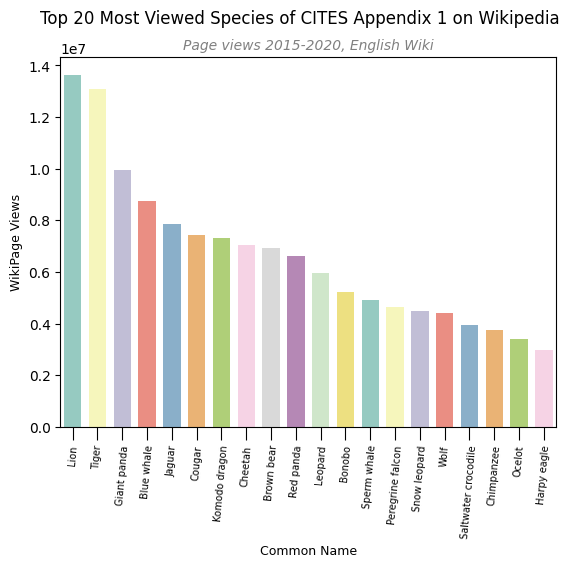

In [82]:
import seaborn as sns

ax = sns.barplot(
    x = 'name',
    y = 'views',
    #hue = 'Kingdom',
    data = top20, 
    width = 0.7, palette = 'Set3', dodge = False
)
ax.set_xlabel('Common Name', fontsize=9)
ax.set_ylabel('WikiPage Views', fontsize=9)


# Add suptitle above the title
plt.suptitle("Top 20 Most Viewed Species of CITES Appendix 1 on Wikipedia\n", fontsize=12)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('Page views 2015-2020, English Wiki', fontsize = 10, color="grey", style='italic')


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 7, left = True)
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('figures/top_20_commonnames_wiki.png', bbox_inches = 'tight')

### Google Hits 

In [65]:
google = pd.read_csv("csv/google_hits_species.csv", sep = ";")
google = google.drop_duplicates().reset_index(drop = True)

In [76]:
top20google = google.nlargest(columns = "gl_hits", n = 20)

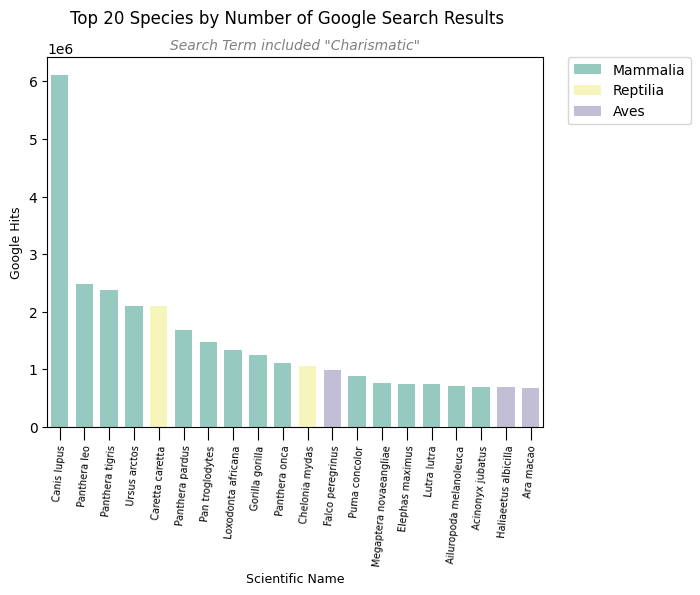

In [80]:
import seaborn as sns

ax = sns.barplot(
    x = 'scientific_name',
    y = 'gl_hits',
    hue = 'Class',
    data = top20google, 
    width = 0.7, palette = 'Set3', dodge = False
)
ax.set_xlabel('Scientific Name', fontsize=9)
ax.set_ylabel('Google Hits', fontsize=9)


# Add suptitle above the title
plt.suptitle("Top 20 Species by Number of Google Search Results\n", fontsize=12)

# Add title
#ax.title("Realized by the Python Graph Gallery", color="grey", style='italic')
ax.set_title('Search Term included "Charismatic"', fontsize = 10, color="grey", style='italic')


ax.tick_params(axis='x', rotation=85, length = 9, labelsize = 7, left = True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig('figures/top_20_species_google.png', bbox_inches = 'tight')